In [4]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-ixjpbtgx
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-ixjpbtgx
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit b8aed82115801ab8818631013eb8672becd56ead
  Preparing metadata (setup.py) ... done


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [37]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper, MappingWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
from gym_neu_racing.sensor_models.sensor_model import SensorModel
from gym_neu_racing.envs.map import Map
from skimage.draw import line
from gym_neu_racing.sensor_models import Lidar2D
from scipy.linalg import expm
import scipy.linalg


ModuleNotFoundError: No module named 'bresenham'

In [ ]:
class ParticleFilter:
    def __init__(
        self,
        map=None,
        num_particles=5,
        sigma_l=0.05,
        sigma_r=0.05,
        sigma_p=0.10,
        r=0.25,
        w=0.5,
        dt=0.1,
    ):
        self.num_particles = num_particles
        self.sigma_l = sigma_l
        self.sigma_r = sigma_r
        self.sigma_p = sigma_p
        self.r = r
        self.w = w
        self.dt = dt
        self.map = map
        self.particles = np.tile(np.eye(3), (num_particles, 1, 1))

        self.sigma_inv = np.linalg.inv(
            np.diag([self.sigma_p**2, self.sigma_p**2])
        )

    def get_pos_mean_and_cov(self) -> tuple[np.ndarray, np.ndarray]:
        """Extract mean/cov of position over all particles."""
        positions = self.particles[:, 0:2, 2]
        pos_mean = np.mean(positions, axis=0)
        pos_cov = np.cov(positions[:, 0], positions[:, 1])
        return pos_mean, pos_cov

    def step(self, obs: dict) -> np.ndarray:
        propagated_particles = self.propagate(obs["wheel_speeds"])
        updated_particles = self.update(propagated_particles)
        return updated_particles

    def propagate(self, wheel_speeds):
        phi_l, phi_r = np.array(wheel_speeds)
        phi_l = phi_l + np.random.normal(0, self.sigma_l)
        phi_r = phi_r + np.random.normal(0, self.sigma_r)

        vel = np.array([[0 , -self.r/self.w*(phi_r - phi_l), self.r/2*(phi_r + phi_l)],
                        [self.r/self.w*(phi_r - phi_l), 0,0],
                        [0,0,0]])

        for i in range(self.num_particles):
            exp = scipy.linalg.expm(vel*self.dt)
            self.particles[i] = self.particles[i]@exp

        return self.particles.copy()

    def update(self, observation) -> np.ndarray:
        """Re-sample particles based on an incoming measurement."""
        x,y = observation
        positions = self.particles[:, 0:2, 2]
        weights = (np.exp(-0.5 * np.sum((positions - observation) ** 2, axis=1) / self.sigma_p ** 2))/(2*np.pi*self.sigma_p**2)
        weights /= np.sum(weights)
        indices = np.random.choice(self.num_particles, size=self.num_particles, p=weights)
        self.particles = self.particles[indices]

        return self.particles.copy()

Time: 0.0
Position Estimate Mean:
 [1.38717415 1.43054901]
Position Estimate Covariance:
 [[1.97412639e-31 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
--
Time: 5.0
Position Estimate Mean:
 [0.29061723 3.2391696 ]
Position Estimate Covariance:
 [[ 3.08457248e-33 -9.87063195e-32]
 [-9.87063195e-32  3.15860222e-30]]
--
Time: 10.0
Position Estimate Mean:
 [-1.90207529  3.19099997]
Position Estimate Covariance:
 [[ 1.97412639e-31 -3.94825278e-31]
 [-3.94825278e-31  7.89650556e-31]]
--
Time: 15.0
Position Estimate Mean:
 [-2.68075147  1.26624012]
Position Estimate Covariance:
 [[1.77671375e-30 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
--


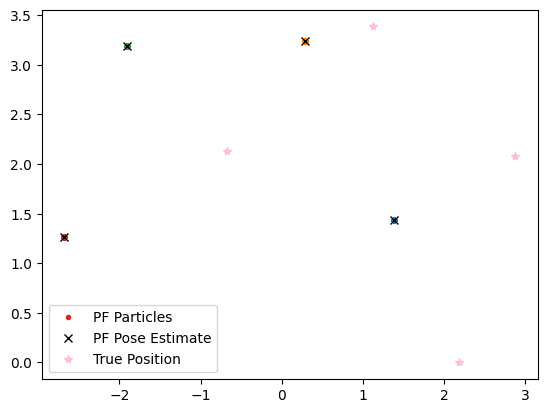

In [ ]:
def run_dead_reckoning(env, robot_radius, robot_wheel_spacing, action, num_particles, dt):

    # wheel speed sensor is only sensor that simulator should model here
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
    }
    env.unwrapped.dt = dt

    # set up environment
    np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.0, 0.0, 0.0])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = ParticleFilter(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
    )

    for t in np.arange(start=0, stop=20., step=dt):

        # propagate particles every dt seconds using wheel speed measurements
        localizer.propagate(obs["wheel_speeds"])
        pos_mean, pos_cov = localizer.get_pos_mean_and_cov()
        obs, _, _, _, _ = env.step(action)

        # visualize positions of particles every dt seconds
        particles = localizer.particles.copy()
        plt.plot(particles[:, 0, 2], particles[:, 1, 2], ".", label="PF Particles")
        plt.plot(pos_mean[0], pos_mean[1], "x", c="k", label="PF Pose Estimate")
        plt.plot(
          env.unwrapped.state[0], env.unwrapped.state[1], "*", c="pink", label="True Position"
        )

        print(f"Time: {t}")
        print(f"Position Estimate Mean:\n {pos_mean}")
        print(f"Position Estimate Covariance:\n {pos_cov}")
        print("--")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([0.4375, 0.25])
num_particles = 1000
dt = 5.0
run_dead_reckoning(env, robot_radius, robot_wheel_spacing, action, num_particles, dt)

kar bhai [[1.65800729 1.25953408]
 [1.65800729 1.25953408]
 [1.65800729 1.25953408]
 ...
 [1.65800729 1.25953408]
 [1.65800729 1.25953408]
 [1.65800729 1.25953408]]
Time: 5.0
Position Estimate Mean: [1.65800729 1.25953408]
Position Estimate Covariance: [[ 4.93531597e-32 -9.87063195e-32]
 [-9.87063195e-32  1.97412639e-31]]
--
kar bhai [[0.98890589 3.20090126]
 [0.98890589 3.20090126]
 [0.98890589 3.20090126]
 ...
 [0.98890589 3.20090126]
 [0.98890589 3.20090126]
 [0.98890589 3.20090126]]
Time: 10.0
Position Estimate Mean: [0.98890589 3.20090126]
Position Estimate Covariance: [[4.93531597e-32 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
--
kar bhai [[-1.06415527  3.16227225]
 [-1.06415527  3.16227225]
 [-1.06415527  3.16227225]
 ...
 [-1.06415527  3.16227225]
 [-1.06415527  3.16227225]
 [-1.06415527  3.16227225]]
Time: 15.0
Position Estimate Mean: [-1.06415527  3.16227225]
Position Estimate Covariance: [[4.93531597e-32 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
--
kar bhai [[

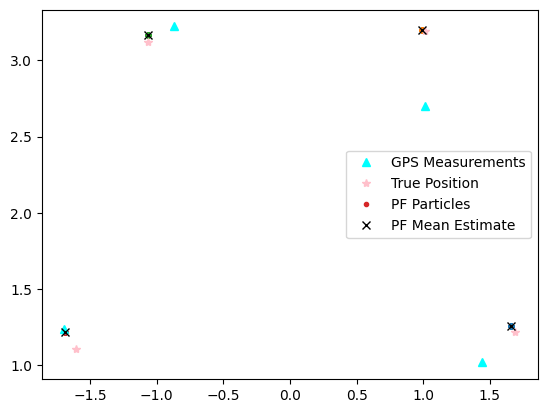

In [ ]:
def run_particle_filter_with_gps(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, gps_freq):

    # simulator should model a wheel speed sensor and GPS at each timestep
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
        "gps": sensor_models.GPS(gps_variance=0.5**2),
    }
    env.unwrapped.dt = dt

    # initialize the system at the origin
    np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.0, 0.0, 0.0])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = ParticleFilter(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
    )

    for t in np.arange(start=0, stop=20.1, step=dt):
        obs, _, _, _, _ = env.step(action)

        # propagate the particles every dt seconds with the current wheel speeds
        localizer.propagate(obs["wheel_speeds"])

        # update the particles every gps_freq seconds with the current GPS measurement
        if (t % gps_freq < 0.01 or t % gps_freq > gps_freq - 0.01) and t > 0:
            localizer.update(obs["gps"])
            plt.plot(obs["gps"][0], obs["gps"][1], "^", c="cyan", label="GPS Measurements")
            plt.plot(
                env.unwrapped.state[0], env.unwrapped.state[1], "*", c="pink", label="True Position"
            )

            particles = localizer.particles
            pos_mean, pos_cov = localizer.get_pos_mean_and_cov()
            obs, _, _, _, _ = env.step(action)

            plt.plot(
                particles[:, 0, 2],
                particles[:, 1, 2],
                ".",
                zorder=0,
                label="PF Particles"
            )
            plt.plot(pos_mean[0], pos_mean[1], "x", c="k", label="PF Mean Estimate")

            print(f"Time: {t}")
            print(f"Position Estimate Mean: {pos_mean}")
            print(f"Position Estimate Covariance: {pos_cov}")
            print("--")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([0.4375, 0.25])
num_particles = 1000
dt = 0.1
gps_freq = 5. # seconds between gps measurements
run_particle_filter_with_gps(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, gps_freq)

In [ ]:
class MCL(ParticleFilter):
    def __init__(
        self,
        map=None,
        num_particles=1000,
        sigma_l=0.05,
        sigma_r=0.05,
        sigma_lidar=1.4,
        r=0.25,
        w=0.5,
        dt=1.0,
    ):
        print(
            f"Instantiating MCL with: {num_particles=}, {sigma_l=}, {sigma_r=}, {sigma_lidar=}, {r=}, {w=}, {dt=}."
        )
        super().__init__(
            num_particles=num_particles,
            sigma_l=sigma_l,
            sigma_r=sigma_r,
            r=r,
            w=w,
            dt=dt,
        )
        self.sigma_lidar = sigma_lidar
        self.map = map

        self.initialize_particles()

        self.lidar_model = Lidar2D(map)

    def initialize_particles(self) -> None:

        # for example...
        # - uniformly randomly sample (x,y) within [[-self.map.x_width / 2, -self.map.y_width / 2], [self.map.x_width / 2, self.map.y_width / 2]]
        # - transform (x,y) point into map indices using self.map.world_coordinates_to_map_indices
        # - check if that cell is free using self.map.static_map[...]
        # - if free, randomly sample a heading angle theta
        # - populate the SE(2) matrix corresponding to that (x, y, theta)
        # - add that SE(2) matrix to self.particles
        # --> self.particles should be a np array of shape (num_particles, 3, 3) after this function is done

        self.particles = np.zeros((self.num_particles, 3, 3))
        count = 0

        while count < self.num_particles:
           x = np.random.uniform(-self.map.x_width / 2, self.map.x_width / 2)
           y = np.random.uniform(-self.map.y_width / 2, self.map.y_width / 2)
           theta = np.random.uniform(-np.pi, np.pi)

           posn = np.array([x,y])

           map_indices = self.map.world_coordinates_to_map_indices(posn)
           x_ind, y_ind = map_indices[0].T
          #  print("have a look", map_indices[0].T)

           if self.map.static_map[x_ind, y_ind] == 0:
            self.particles[count] = np.array([
                [np.cos(theta), -np.sin(theta), x],
                [np.sin(theta), np.cos(theta), y],
                [0, 0, 1]
            ])
            count += 1


    def update(self, observation) -> np.ndarray:
        weights = np.zeros(self.num_particles)

        for i in range(self.num_particles):
            x, y = self.particles[i, 0:2, 2]

            theta = np.arctan2(self.particles[i, 1, 0], self.particles[i, 0, 0])
            ideal_scan = self.lidar_model.step([x, y, theta], None)
            # print("obs scan", observation)
            # print("see this",ideal_scan, type(ideal_scan))

            actual_scan = observation["ranges"]
            diff = (np.exp(-0.5 * np.sum((actual_scan - ideal_scan["ranges"]) ** 2) / self.sigma_lidar ** 2))/(2*np.pi*self.sigma_lidar**2)
            weights[i] = np.prod(diff)
            # print("weights", weights[i])

        weights /= np.sum(weights)
        indices = np.random.choice(self.num_particles, size=self.num_particles, p=weights)
        self.particles = self.particles[indices]

        return self.particles.copy()

Instantiating MCL with: num_particles=1000, sigma_l=0.5, sigma_r=0.5, sigma_lidar=1.4, r=0.25, w=0.5, dt=1.0.


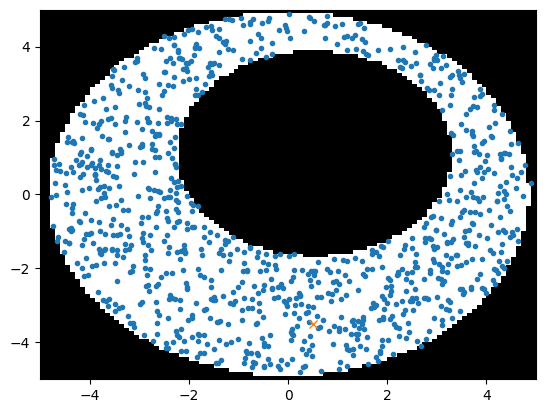

lap completed!
clockwise -> fwd lap completed


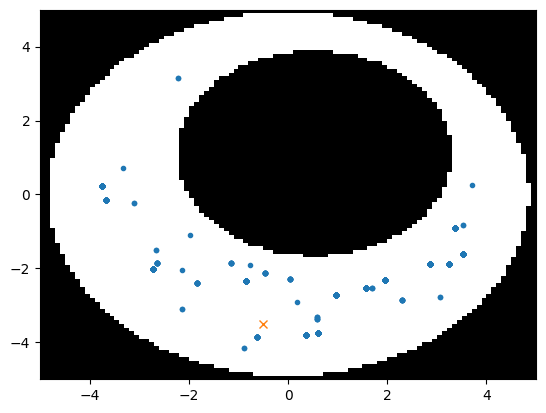

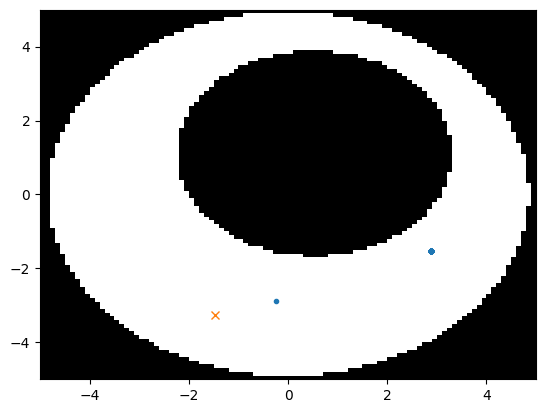

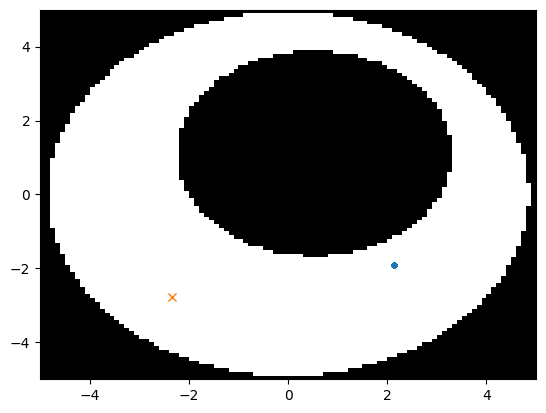

In [ ]:
def run_monte_carlo_localization(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, sigma_l, sigma_r, sigma_lidar, lidar_freq):

    # environment will simulate wheel speed sensor and lidar sensor
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
        "lidar": sensor_models.Lidar2D(env.unwrapped.map),
    }
    env.unwrapped.dt = dt

    # initialize the robot in a specific state to make experiments repeatable
    # np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.5, -3.5, np.pi])
    # env.unwrapped.state = np.array([-3.2, 0.0, np.pi / 2])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = MCL(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
        sigma_l=sigma_l,
        sigma_r=sigma_r,
        sigma_lidar=sigma_lidar,
        map=env.unwrapped.map,
    )

    # draw map and overlay intial particle positions
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        localizer.particles[:, 0, 2], localizer.particles[:, 1, 2], "."
    )
    ax.plot(env.unwrapped.state[0], env.unwrapped.state[1], "x")
    plt.show()

    localizer.update(obs["lidar"])
    for t in np.arange(start=0, stop=2.1, step=dt):
        obs, _, _, _, _ = env.step(action)

        # every dt seconds, propagate particles using wheel speeds
        localizer.propagate(obs["wheel_speeds"])

        # every lidar_freq seconds, update particles using lidar reading
        if (t % lidar_freq < 0.01 or t % lidar_freq > lidar_freq - 0.01) and t > 0:
            localizer.update(obs["lidar"])

        # draw map and overlay intial particle positions
        ax = env.unwrapped.map.draw_map(show=False)
        ax.plot(
            localizer.particles[:, 0, 2], localizer.particles[:, 1, 2], "."
        )

        # plot true state - just for visualization, shouldn't use this info in your estimator ;)
        ax.plot(env.unwrapped.state[0], env.unwrapped.state[1], "x")
        plt.show()

env = gymnasium.make("gym_neu_racing/NEURacing-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([1.0, -0.25])
num_particles = 1000
dt = 1.0
sigma_l = 0.5
sigma_r = 0.5
sigma_lidar = 1.4
lidar_freq = 1.0
run_monte_carlo_localization(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, sigma_l, sigma_r, sigma_lidar, lidar_freq)

# Note: Once you're happy with the performance of your MCL, make sure to set the
# default values in the MCL class definition, because the autograder will simply
# run MCL(dt=dt, r=robot_radius, w=robot_wheel_spacing, map=env.unwrapped.map)
# to instantiate your class. Any other parameters (e.g., sigma_l, sigma_lidar)
# will take their default values according to your class definition, not the
# ones listed near the bottom of this cell.

In [6]:
def log_odds_to_prob(log_odds: np.ndarray) -> np.ndarray:
    return 1 - 1 / (1 + np.exp(log_odds))

def prob_to_log_odds(prob: np.ndarray) -> np.ndarray:
    return np.log(prob / (1 - prob))

In [379]:
class Mapper:
    def __init__(
        self, p_free: float = 0.2, p_occ: float = 0.8, p_prior: float = 0.5
    ):
        self.map = Map(x_width=10, y_width=10, grid_cell_size=0.1)

        # feel free to change the default values for p_free, p_occ, p_prior!
        self.p_free = p_free
        self.p_occ = p_occ
        self.p_prior = p_prior
        self.log_odds_free = prob_to_log_odds(p_free)
        self.log_odds_occ = prob_to_log_odds(p_occ)
        self.log_odds_prior = prob_to_log_odds(p_prior)

        # initialize with P(occ) = 0.5 for all cells (unknown) -- feel free to change this!
        self.map.log_odds_map = np.zeros(
            self.map.static_map.shape, dtype=float
        )

    # If someone calls Mapper().probability_map, this method will run and convert
    # the current `self.map.log_odds_map` to an array of probabilities per cell.
    # You don't need to explicitly store `self.probability_map` and can just keep
    # `self.log_odds_map` updated ("properties" are a useful Python concept).
    @property
    def probability_map(self):
        return log_odds_to_prob(self.map.log_odds_map)

    def step(self, obs):
        """Using current state & lidar, update esimated gridmap log-odds."""
        r_x,r_y,theta = obs["state"]
        step_x,step_y = 0,0
        r_state = np.array([r_x,r_y])
        robot_grid = self.map.world_coordinates_to_map_indices(r_state)
        rg_x,rg_y = robot_grid[0].T
        # print("robot grid", rg_x)

        lidar_angles = obs["lidar"]["angles"]
        hit_points = []
        # print("states",obs["state"])
        lidar_readings = obs["lidar"]["ranges"]
        # print("lidar readings", lidar_angles)

        for i, d in enumerate(lidar_readings):
          if d <= 0 or d > 10:
            continue

          angle = theta + lidar_angles[i]
          hit_x = r_x + d * np.cos(angle)
          hit_y = r_y + d * np.sin(angle)
          hit_points.append([hit_x, hit_y])

        hit_points = np.array(hit_points)
        map_indices = self.map.world_coordinates_to_map_indices(hit_points)
        h_x, h_y = map_indices[0].T



        for i in range(len(h_x)):

           rr, cc = line(int(round(rg_x)), int(round(rg_y)), h_x[i], h_y[i])


           for r, c in zip(rr[:-1], cc[:-1]):
              if 0 <= r < self.map.log_odds_map.shape[0] and 0 <= c < self.map.log_odds_map.shape[1]:
                  self.map.log_odds_map[r, c] += self.log_odds_free - self.log_odds_prior


            # Update the hit point cell as occupied
           if 0 <= h_x[i] < self.map.log_odds_map.shape[0] and 0 <= h_y[i] < self.map.log_odds_map.shape[1]:
                self.map.log_odds_map[h_x[i], h_y[i]] += self.log_odds_occ - self.log_odds_prior


        estimated_map = self.probability_map.copy()

        return estimated_map

lap completed!
clockwise -> fwd lap completed


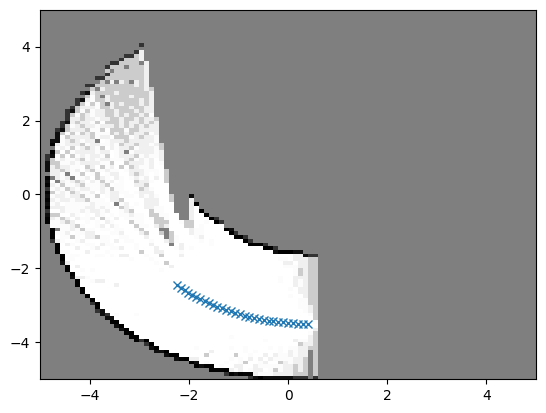

In [381]:
env = gymnasium.make("gym_neu_racing/NEURacing-v0")
env = MappingWrapper(env)

# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# Tell the environment to use your new Lidar2D sensor
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "lidar": sensor_models.Lidar2D(env.unwrapped.map),
}

# Reset the environment and get the first observation (state + lidar)
obs, _ = env.reset()

# initialize the robot in a particular state (feel free to start from different places when testing your algorithm)
env.unwrapped.state = np.array([0.5, -3.5, np.pi])
obs["state"] = env.unwrapped.state
obs["lidar"] = env.unwrapped.sensor_models["lidar"].step(obs["state"], None)

mapper = Mapper()

states = []

# run the simulator & mapper for num_timesteps to build a complete map of the environment
num_timsteps = 30
for _ in range(num_timsteps):
    estimated_map = mapper.step(obs)
    action = np.array([1.0, -0.25])
    obs, _, _, _, _ = env.step(action)

    # keep track of the current state, just for visualization later
    states.append(obs["state"])

# draw your best guess of the environment map along with your robot's trajectory
mapper.map.static_map = estimated_map.copy()
mapper.map.draw_map(show=False)
plt.plot([state[0] for state in states], [state[1] for state in states], "x")
plt.show()